Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)         2

Epoch 1/20
468/468 [==============================] - 635s 1s/step - loss: 2.3999 - accuracy: 0.1915 - val_loss: 2.4986 - val_accuracy: 0.0983 - lr: 1.0000e-07
Epoch 2/20
468/468 [==============================] - 648s 1s/step - loss: 2.4046 - accuracy: 0.1887 - val_loss: 2.5006 - val_accuracy: 0.0955 - lr: 1.0000e-07
Epoch 3/20
468/468 [==============================] - 669s 1s/step - loss: 2.4121 - accuracy: 0.1845 - val_loss: 2.4994 - val_accuracy: 0.0972 - lr: 1.0000e-07
Epoch 4/20
468/468 [==============================] - 669s 1s/step - loss: 2.3977 - accuracy: 0.1939 - val_loss: 2.4975 - val_accuracy: 0.0955 - lr: 1.0000e-07
Epoch 5/20
468/468 [==============================] - 591s 1s/step - loss: 2.4150 - accuracy: 0.1807 - val_loss: 2.4959 - val_accuracy: 0.0975 - lr: 1.0000e-07
Epoch 6/20
468/468 [==============================] - 525s 1s/step - loss: 2.4155 - accuracy: 0.1837 - val_loss: 2.5153 - val_accuracy: 0.0960 - lr: 5.0000e-06
Epoch 7/20
468/468 [====================

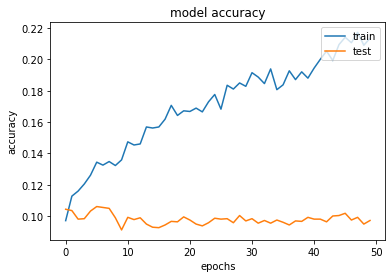

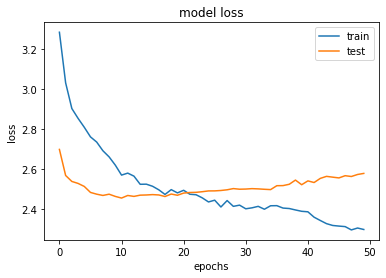

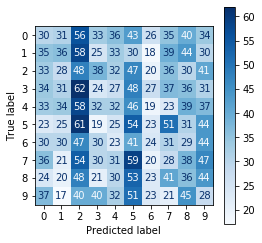

In [1]:
# with fine tuning
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

%matplotlib inline

# example of horizontal shift image augmentation
from numpy import expand_dims
from tensorflow import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.models import Model

from keras.optimizers import RMSprop
from keras.optimizers import Adam

# pre-trained models
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

from keras.layers import BatchNormalization as BatchNorm
import tensorflow as tf
import math

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from learning_rate import decayed_learning_rate, decayed_learning_rate_tuned

np.random.seed(1)
tf.random.set_seed(1)

# dataset details
train_data_dir =      './Data/Online/online_pendigits/offline/train/'
validation_data_dir = './Data/Online/online_pendigits/offline/test/'
nb_train_samples = 7494
nb_validation_samples = 3498
num_classes = 10

epochs = 30
batch_size = 16
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16
# load model without classifier layers
model = Sequential()
# # create the VGG16 model with only the convolutional layers, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# mark loaded layers as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                #     rotation_range=5,
                #     shear_range=0.1,
                #     validation_split=0.2,
                #     zoom_range=0.05,
                # #     fill_mode='nearest'
                #     horizontal_flip=False
                )

# this is the augmentation configuration we will use for testing:
# only rescaling for test dataset
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
#     subset='training',
    shuffle=True,
    seed=13)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
#     subset='validation',
    shuffle=False,
    class_mode='categorical')

# custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(decayed_learning_rate)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)


# fine tuning the model
epochs = 20

# mark layers as trainable
for layer in model.layers[:12]:
    layer.trainable = True

train_generator.reset()
validation_generator.reset()

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(decayed_learning_rate_tuned)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

# model.save_weights('first_try0.h5')

# summarize history for accuracy
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

filenames = validation_generator.filenames

predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)

cm = confusion_matrix(validation_generator.classes,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=clf.classes_)

fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
disp.plot(ax=ax, cmap=plt.cm.Blues)

In [2]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.09812476047554677
recall_score   :  0.09709931309395887
f1_score       :  0.09614388193104859
accuracy_score :  0.09719839908519154

Best accuracy  :  0.10607798397541046


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

Epoch 1/20
468/468 [==============================] - 293s 627ms/step - loss: 2.4056 - accuracy: 0.1768 - val_loss: 2.4943 - val_accuracy: 0.1021 - lr: 1.0000e-07
Epoch 2/20
468/468 [==============================] - 299s 639ms/step - loss: 2.3863 - accuracy: 0.1865 - val_loss: 2.4939 - val_accuracy: 0.1009 - lr: 1.0000e-07
Epoch 3/20
468/468 [==============================] - 296s 632ms/step - loss: 2.3898 - accuracy: 0.1894 - val_loss: 2.4932 - val_accuracy: 0.0986 - lr: 1.0000e-07
Epoch 4/20
468/468 [==============================] - 290s 621ms/step - loss: 2.3951 - accuracy: 0.1827 - val_loss: 2.4959 - val_accuracy: 0.1021 - lr: 1.0000e-07
Epoch 5/20
468/468 [==============================] - 300s 641ms/step - loss: 2.4021 - accuracy: 0.1836 - val_loss: 2.4961 - val_accuracy: 0.1021 - lr: 1.0000e-07
Epoch 6/20
468/468 [==============================] - 305s 652ms/step - loss: 2.4144 - accuracy: 0.1900 - val_loss: 2.4992 - val_accuracy: 0.0960 - lr: 5.0000e-06
Epoch 7/20
468/468 [==

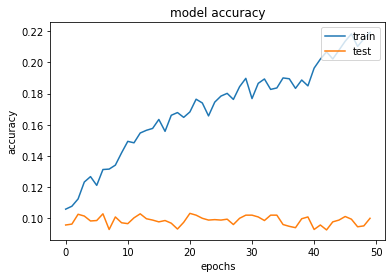

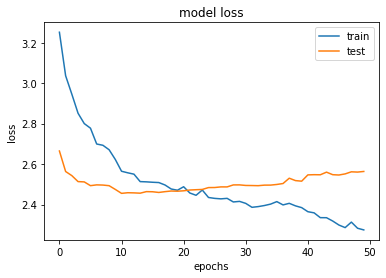

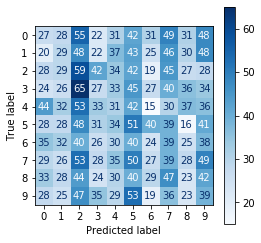

In [3]:
# with fine tuning
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

%matplotlib inline

# example of horizontal shift image augmentation
from numpy import expand_dims
from tensorflow import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.models import Model

from keras.optimizers import RMSprop
from keras.optimizers import Adam

# pre-trained models
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

from keras.layers import BatchNormalization as BatchNorm
import tensorflow as tf
import math

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from learning_rate import decayed_learning_rate, decayed_learning_rate_tuned

np.random.seed(1)
tf.random.set_seed(1)

# dataset details
train_data_dir =      './Data/Online/online_pendigits/offline/train/'
validation_data_dir = './Data/Online/online_pendigits/offline/test/'
nb_train_samples = 7494
nb_validation_samples = 3498
num_classes = 10

epochs = 30
batch_size = 16
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16
# load model without classifier layers
model = Sequential()
# # create the VGG16 model with only the convolutional layers, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# mark loaded layers as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                #     rotation_range=5,
                #     shear_range=0.1,
                #     validation_split=0.2,
                #     zoom_range=0.05,
                # #     fill_mode='nearest'
                #     horizontal_flip=False
                )

# this is the augmentation configuration we will use for testing:
# only rescaling for test dataset
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
#     subset='training',
    shuffle=True,
    seed=13)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
#     subset='validation',
    shuffle=False,
    class_mode='categorical')

# custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(decayed_learning_rate)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)


# fine tuning the model
epochs = 20

# mark layers as trainable
for layer in model.layers[:12]:
    layer.trainable = True

train_generator.reset()
validation_generator.reset()

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(decayed_learning_rate_tuned)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

# model.save_weights('first_try0.h5')

# summarize history for accuracy
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

filenames = validation_generator.filenames

predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)

cm = confusion_matrix(validation_generator.classes,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=clf.classes_)

fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
disp.plot(ax=ax, cmap=plt.cm.Blues)

In [4]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.09805253138864914
recall_score   :  0.0995860054958175
f1_score       :  0.09753965292615767
accuracy_score :  0.09977129788450544

Best accuracy  :  0.10321100801229477


In [5]:
# with fine tuning
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

%matplotlib inline

# example of horizontal shift image augmentation
from numpy import expand_dims
from tensorflow import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.models import Model

from keras.optimizers import RMSprop
from keras.optimizers import Adam

# pre-trained models
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

from keras.layers import BatchNormalization as BatchNorm
import tensorflow as tf
import math

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from learning_rate import decayed_learning_rate, decayed_learning_rate_tuned

np.random.seed(1)
tf.random.set_seed(1)

# dataset details
train_data_dir =      './Data/Online/online_pendigits/offline/train/'
validation_data_dir = './Data/Online/online_pendigits/offline/test/'
nb_train_samples = 7494
nb_validation_samples = 3498
num_classes = 10

epochs = 30
batch_size = 16
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16
# load model without classifier layers
model = Sequential()
# # create the VGG16 model with only the convolutional layers, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# mark loaded layers as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                #     rotation_range=5,
                #     shear_range=0.1,
                #     validation_split=0.2,
                #     zoom_range=0.05,
                # #     fill_mode='nearest'
                #     horizontal_flip=False
                )

# this is the augmentation configuration we will use for testing:
# only rescaling for test dataset
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
#     subset='training',
    shuffle=True,
    seed=13)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
#     subset='validation',
    shuffle=False,
    class_mode='categorical')

# custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(decayed_learning_rate)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)


# fine tuning the model
epochs = 20

# mark layers as trainable
for layer in model.layers[:12]:
    layer.trainable = True

train_generator.reset()
validation_generator.reset()

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(decayed_learning_rate_tuned)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

# model.save_weights('first_try0.h5')

# summarize history for accuracy
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

filenames = validation_generator.filenames

predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)

cm = confusion_matrix(validation_generator.classes,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=clf.classes_)

fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
disp.plot(ax=ax, cmap=plt.cm.Blues)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

KeyboardInterrupt: 

In [ ]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

In [ ]:
# with fine tuning
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

%matplotlib inline

# example of horizontal shift image augmentation
from numpy import expand_dims
from tensorflow import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.models import Model

from keras.optimizers import RMSprop
from keras.optimizers import Adam

# pre-trained models
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

from keras.layers import BatchNormalization as BatchNorm
import tensorflow as tf
import math

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from learning_rate import decayed_learning_rate, decayed_learning_rate_tuned

np.random.seed(1)
tf.random.set_seed(1)

# dataset details
train_data_dir =      './Data/Online/online_pendigits/offline/train/'
validation_data_dir = './Data/Online/online_pendigits/offline/test/'
nb_train_samples = 7494
nb_validation_samples = 3498
num_classes = 10

epochs = 30
batch_size = 16
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16
# load model without classifier layers
model = Sequential()
# # create the VGG16 model with only the convolutional layers, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# mark loaded layers as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                #     rotation_range=5,
                #     shear_range=0.1,
                #     validation_split=0.2,
                #     zoom_range=0.05,
                # #     fill_mode='nearest'
                #     horizontal_flip=False
                )

# this is the augmentation configuration we will use for testing:
# only rescaling for test dataset
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
#     subset='training',
    shuffle=True,
    seed=13)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
#     subset='validation',
    shuffle=False,
    class_mode='categorical')

# custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(decayed_learning_rate)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)


# fine tuning the model
epochs = 20

# mark layers as trainable
for layer in model.layers[:12]:
    layer.trainable = True

train_generator.reset()
validation_generator.reset()

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(decayed_learning_rate_tuned)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

# model.save_weights('first_try0.h5')

# summarize history for accuracy
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

filenames = validation_generator.filenames

predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)

cm = confusion_matrix(validation_generator.classes,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=clf.classes_)

fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
disp.plot(ax=ax, cmap=plt.cm.Blues)

In [ ]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

In [ ]:
# with fine tuning
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

%matplotlib inline

# example of horizontal shift image augmentation
from numpy import expand_dims
from tensorflow import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.models import Model

from keras.optimizers import RMSprop
from keras.optimizers import Adam

# pre-trained models
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

from keras.layers import BatchNormalization as BatchNorm
import tensorflow as tf
import math

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from learning_rate import decayed_learning_rate, decayed_learning_rate_tuned

np.random.seed(1)
tf.random.set_seed(1)

# dataset details
train_data_dir =      './Data/Online/online_pendigits/offline/train/'
validation_data_dir = './Data/Online/online_pendigits/offline/test/'
nb_train_samples = 7494
nb_validation_samples = 3498
num_classes = 10

epochs = 30
batch_size = 16
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16
# load model without classifier layers
model = Sequential()
# # create the VGG16 model with only the convolutional layers, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# mark loaded layers as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                #     rotation_range=5,
                #     shear_range=0.1,
                #     validation_split=0.2,
                #     zoom_range=0.05,
                # #     fill_mode='nearest'
                #     horizontal_flip=False
                )

# this is the augmentation configuration we will use for testing:
# only rescaling for test dataset
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
#     subset='training',
    shuffle=True,
    seed=13)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
#     subset='validation',
    shuffle=False,
    class_mode='categorical')

# custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(decayed_learning_rate)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)


# fine tuning the model
epochs = 20

# mark layers as trainable
for layer in model.layers[:12]:
    layer.trainable = True

train_generator.reset()
validation_generator.reset()

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(decayed_learning_rate_tuned)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

# model.save_weights('first_try0.h5')

# summarize history for accuracy
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

filenames = validation_generator.filenames

predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)

cm = confusion_matrix(validation_generator.classes,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=clf.classes_)

fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
disp.plot(ax=ax, cmap=plt.cm.Blues)

In [ ]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))